# Análisis de Foro del Programa Nacional de Formaciön Docente en Servicio

## Origen de datos

In [44]:
# Librerias a usar 
import pandas as pd 
import pyodbc 
import re 
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import joblib 

In [3]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BA',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [4]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT  * FROM [dbo].[MON_foros]
            WHERE usuario_post_forum not in ('2','3','19797','276201') and dni != '' and curso_id = 26"""
    
foros_df = pd.read_sql_query(query1,conn)

#Cerrar la conexion
conn.close()

C:\Users\DIFODS103\AppData\Local\Temp\ipykernel_17368\2424577046.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  foros_df = pd.read_sql_query(query1,conn)


In [14]:
foros_df.head()

,curso_id,foro_id,nombre_debate,usuario_diss_forum,usuario_post_forum,mensaje,dni,grupo_id
0,26,61,Foro: Mensaje de bienvenida,3,8209,"buenas noches, colegas mi nombre es jesusa mar...",23720134,1005
1,26,61,Foro: Mensaje de bienvenida,3,278376,buenas tardes soy la docente d'yana mayta del ...,70994318,1005
2,26,61,Foro: Mensaje de bienvenida,3,278841,"buenas tardes colegas, mi nombre es sylvia jos...",08370218,1005
3,26,61,Foro: Mensaje de bienvenida,3,299000,"buenas noches colegas, mi nombre es edith illo...",41275738,1005
4,26,61,Foro: Mensaje de bienvenida,3,276484,buenas tardes mi nombres es roxana del carmen ...,03635669,1005


## Selección, limpieza y transformación

In [15]:
mensaje = foros_df['mensaje']
mensaje

0       buenas noches, colegas mi nombre es jesusa mar...
1       buenas tardes soy la docente d'yana mayta del ...
2       buenas tardes colegas, mi nombre es sylvia jos...
3       buenas noches colegas, mi nombre es edith illo...
4       buenas tardes mi nombres es roxana del carmen ...
                              ...                        
3825    buenas noches  mi nombres luz eldith pinedo ra...
3826    bienvenida alicia geraldine!la participación d...
3827    muy buenos días estimado maestro alejandro  es...
3828    bienvenida luz eldith, el área de desarrollo p...
3829    buenos días alicia, gracias por sus aportes, t...
Name: mensaje, Length: 3830, dtype: object

In [16]:
# Convertir a minúsculas
mensaje= mensaje.str.lower()
# Eliminar signos de puntuación
mensaje = mensaje.apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [17]:
# Tokenización
mensaje = mensaje.apply(word_tokenize)
mensaje

0       [buenas, noches, colegas, mi, nombre, es, jesu...
1       [buenas, tardes, soy, la, docente, dyana, mayt...
2       [buenas, tardes, colegas, mi, nombre, es, sylv...
3       [buenas, noches, colegas, mi, nombre, es, edit...
4       [buenas, tardes, mi, nombres, es, roxana, del,...
                              ...                        
3825    [buenas, noches, mi, nombres, luz, eldith, pin...
3826    [bienvenida, alicia, geraldinela, participació...
3827    [muy, buenos, días, estimado, maestro, alejand...
3828    [bienvenida, luz, eldith, el, área, de, desarr...
3829    [buenos, días, alicia, gracias, por, sus, apor...
Name: mensaje, Length: 3830, dtype: object

In [19]:
# Eliminación de stop words
custom_stopwords = set(['buenas','buenos','dias','tardes','tengo','espero','ie','auala','aula','traves','tener','espero',
                        'promuevo','promover','democracia','intercultural','convivencia','áreas','competencia',
                        'desarrollo','lectura','leer','lectora','desarrollar','tener','realizar','hacer',
                        'curricular','diverso','diferente','noches','estimada','estimadas'])

stop_words = set(stopwords.words('spanish'))

stop_words.update(custom_stopwords)
mensaje = mensaje.apply(lambda x: [word for word in x if word not in stop_words])

In [20]:
# Lematización
lemmatizer = WordNetLemmatizer()
mensaje = mensaje.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [21]:
mensaje[1]

['docente',
 'dyana',
 'mayta',
 'nivel',
 'inicial',
 'vivo',
 'lima',
 'disrito',
 'santa',
 'anita']

In [22]:
foros_df['mensaje'][1]

"buenas tardes soy la docente d'yana mayta del nivel inicial, vivo en lima en el disrito de santa anita."

In [23]:
# Unir tokens nuevamente en mensajes
mensaje = mensaje.apply(lambda x: ' '.join(x))

In [24]:
mensaje

0       colegas nombre jesusa martinez zarabia docente...
1       docente dyana mayta nivel inicial vivo lima di...
2       colegas nombre sylvia josefina orejuela flores...
3       colegas nombre edith illo capcha trabajo regió...
4       nombres roxana carmen gallo gutiérrez docente ...
                              ...                        
3825    nombres luz eldith pinedo ramírez docente inst...
3826    bienvenida alicia geraldinela participación es...
3827    días estimado maestro alejandro importante res...
3828    bienvenida luz eldith área personal ciudadanía...
3829        días alicia gracias aportes bienvenido éxitos
Name: mensaje, Length: 3830, dtype: object

## Mineria de Texto

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
# Crear una matriz de términos (bag of words) usando CountVectorizer
vectorizer = CountVectorizer(max_features=500)  # Puedes ajustar el número de características
X = vectorizer.fit_transform(mensaje)

In [27]:
# Aplicar el modelo LDA
num_topics = 5  # Número de tópicos a identificar
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [30]:
#exportar modelo lda
joblib.dump(lda_model,"lda_model1.pkl")

['lda_model1.pkl']

In [31]:
# Mostrar las palabras clave de cada tópico
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[-10:][::-1]  # Las 10 palabras más relevantes
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))
    print()

Topic 1:
estudiantes, democrática, respeto, cada, área, actividades, través, norma, comprensión, trabajo

Topic 2:
diversas, cómo, manera, curriculares, democrática, promueves, desarrollas, estudiantes, preguntas, partir

Topic 3:
estudiantes, democrática, maestra, usted, participación, estrategias, importante, colega, interesante, así

Topic 4:
programa, foro, docente, democrática, formación, servicio, participación, nacional, virtual, experiencia

Topic 5:
docente, estudiantes, nivel, trabajo, nombre, curso, región, grado, expectativas, mejorar



In [32]:
# Obtener la distribución de tópicos para cada mensaje
topic_distribution = lda_model.transform(X)

In [33]:
topic_distribution

array([[0.01015303, 0.01006237, 0.01011409, 0.01041709, 0.95925342],
       [0.03349209, 0.03336648, 0.03334931, 0.03353676, 0.86625536],
       [0.00916296, 0.00913135, 0.00919572, 0.00922269, 0.96328727],
       ...,
       [0.36806604, 0.17081294, 0.44348908, 0.00885192, 0.00878002],
       [0.64517249, 0.00966472, 0.32554356, 0.00984707, 0.00977216],
       [0.03340178, 0.03342119, 0.86489134, 0.03468381, 0.03360188]])

In [34]:
# Asociar cada mensaje al tópico más relevante
topic_assignments = topic_distribution.argmax(axis=1)

In [35]:
topic_assignments

array([4, 4, 4, ..., 2, 0, 2], dtype=int64)

In [36]:
# Agregar las asignaciones de tópicos a tus datos originales
foros_df['topic'] = topic_assignments + 1
foros_df['preprocesado'] = mensaje

In [37]:
foros_df

,curso_id,foro_id,nombre_debate,usuario_diss_forum,usuario_post_forum,mensaje,dni,grupo_id,topic,preprocesado
0,26,61,Foro: Mensaje de bienvenida,3,8209,"buenas noches, colegas mi nombre es jesusa mar...",23720134,1005,5,colegas nombre jesusa martinez zarabia docente...
1,26,61,Foro: Mensaje de bienvenida,3,278376,buenas tardes soy la docente d'yana mayta del ...,70994318,1005,5,docente dyana mayta nivel inicial vivo lima di...
2,26,61,Foro: Mensaje de bienvenida,3,278841,"buenas tardes colegas, mi nombre es sylvia jos...",08370218,1005,5,colegas nombre sylvia josefina orejuela flores...
3,26,61,Foro: Mensaje de bienvenida,3,299000,"buenas noches colegas, mi nombre es edith illo...",41275738,1005,5,colegas nombre edith illo capcha trabajo regió...
4,26,61,Foro: Mensaje de bienvenida,3,276484,buenas tardes mi nombres es roxana del carmen ...,03635669,1005,5,nombres roxana carmen gallo gutiérrez docente ...
...,...,...,...,...,...,...,...,...,...,...
3825,26,61,Bienvenida a todos los participantes!,308399,69098,buenas noches mi nombres luz eldith pinedo ra...,01065600,1406,5,nombres luz eldith pinedo ramírez docente inst...
3826,26,61,Bienvenida a todos los participantes!,308399,321732,bienvenida alicia geraldine!la participación d...,09282796,1406,3,bienvenida alicia geraldinela participación es...
3827,26,61,Bienvenida a todos los participantes!,308399,5703,muy buenos días estimado maestro alejandro es...,29571124,1406,3,días estimado maestro alejandro importante res...
3828,26,61,Bienvenida a todos los participantes!,308399,317091,"bienvenida luz eldith, el área de desarrollo p...",40953915,1406,1,bienvenida luz eldith área personal ciudadanía...


In [38]:
(foros_df['topic'].value_counts() / len(foros_df['topic'])) * 100

topic
5    33.446475
1    25.796345
3    19.347258
4    15.404700
2     6.005222
Name: count, dtype: float64

In [39]:
# Contar la frecuencia de cada tópico
topic_counts = sorted(foros_df['topic'].value_counts())

In [40]:
# Etiquetas de los tópicos
topic_labels = ['Tópico 1', 'Tópico 2', 'Tópico 3', 'Tópico 4', 'Tópico 5']

In [41]:
# Colores para cada tópico
topic_colors = ['blue', 'green', 'orange', 'red', 'purple']

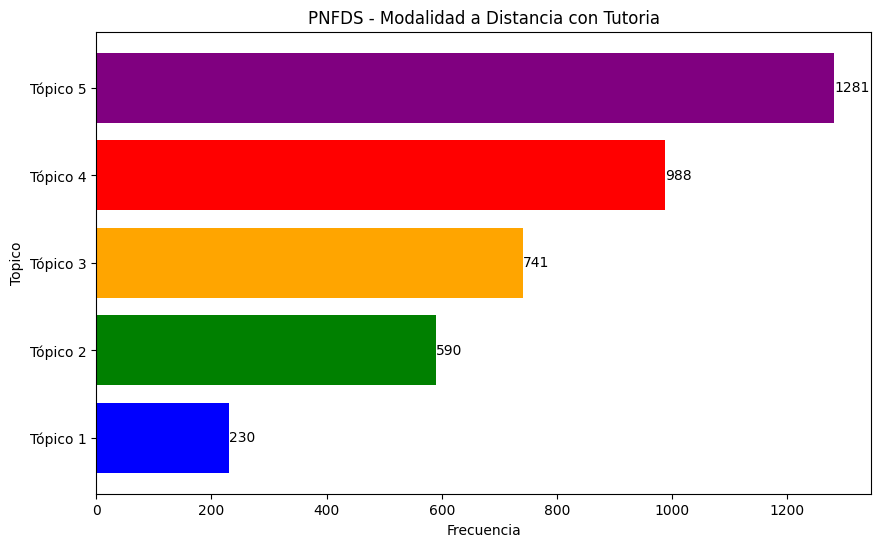

In [45]:
# Ajustar el tamaño de la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras horizontal con colores degradados y orden descendente
ax.barh(topic_labels,topic_counts,color=topic_colors)

# Agregar etiquetas de datos a las barras
for i, count in enumerate(topic_counts):
    plt.text(count, i, str(count), ha='left', va='center')

# Configurar los ejes y el título del gráfico
plt.xlabel('Frecuencia')
plt.ylabel('Topico')
plt.title('PNFDS - Modalidad a Distancia con Tutoria')

# Mostrar la gráfica
plt.show()